# Tensorflow CNN for Patch Classification with Satellite Data 

### Preparing data  
Data sets is "EuroSAT"; 10 land cover categories from industrial to permanent crop, 27k 64x64 pixel chips, 3/16 band Sentinel-2 satellite imagery (10m res.), covering cities in 30 countries.  
Downloading and unzip "EuroSAT (RGB color space images)" datasets from http://madm.dfki.de/downloads to *~/datasets* directory.

This notebook is inspired by https://github.com/rdcolema/tensorflow-image-classification/blob/master/cnn.ipynb.

In [1]:
import time
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

from subprocess import check_output
from datetime import timedelta
from tqdm import tqdm

### Check filenames and data size

In [2]:
data_dir = "../datasets/EuroSAT_RGB/"
cl_nms = os.listdir(data_dir)

# Eliminate hidden file's name
cl_nms = [cl_nms[i] for i in range(len(cl_nms)) if (cl_nms[i][0])!='.']
n_files = []
for c in range(len(cl_nms)):
    volume = len(os.listdir(os.path.join(data_dir, cl_nms[c])))
    n_files.append(volume)
pd_nclass = pd.DataFrame(n_files, index=cl_nms)
pd_nclass = pd_nclass.rename(columns={0 : "# of samples"})
pd_nclass

,# of samples
Highway,2500
PermanentCrop,2500
River,2500
Forest,3000
HerbaceousVegetation,3000
Industrial,2500
AnnualCrop,3000
SeaLake,3000
Pasture,2000
Residential,3000


### Load image data and convert jpeg format to numpy array
Data format of downloaded image data is "jpeg". Therefore, they should be changed to numpy arrary for inputting tensorflow network.

In [3]:
dir_sets = "../datasets/EuroSAT_RGB/"
images = []
labels = []
for dn in range(len(cl_nms)):
    cl_nm = cl_nms[dn]
    file_nm_list = os.listdir(os.path.join(dir_sets, cl_nm))
    for fn in tqdm(range(len(file_nm_list))):
        im = cv2.imread(os.path.join(os.path.join(dir_sets, cl_nm), file_nm_list[fn]))
        images.append(im)
        labels.append(cl_nm)
images = np.array(images)
labels = np.array(labels)
print(images.shape, labels.shape)

100%|██████████| 3000/3000 [00:00<00:00, 3756.43it/s]


(27000, 64, 64, 3) (27000,)


### Check some patches in RGB on display

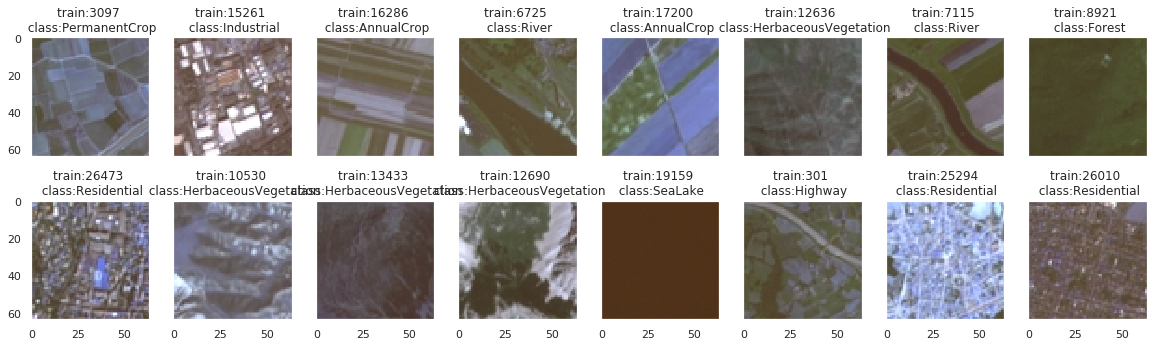

In [4]:
new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(2, 8, sharex='col', sharey='row', figsize=(20, 5.5), facecolor='w')
i = 0
for i in range(16):
    j = np.random.randint(labels.shape[0])
    ax[i // 8, i % 8].imshow(images[j])
    ax[i // 8, i % 8].set_title('train:%d \n class:%s' %(j, labels[j]))
plt.show()

### Apply one-hot encoding to label data

In [5]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

le = preprocessing.LabelEncoder()
print('labels:', cl_nms)
le.fit(cl_nms)
print('number: ', le.transform(cl_nms))

labels_enc = le.transform(labels).reshape(-1,1)
labels_oh = OneHotEncoder(categories='auto').fit_transform(labels_enc).A
print('Dimensionality of one-hot encoded label file:', labels_oh.shape)

labels: ['Highway', 'PermanentCrop', 'River', 'Forest', 'HerbaceousVegetation', 'Industrial', 'AnnualCrop', 'SeaLake', 'Pasture', 'Residential']
number:  [3 6 8 1 2 4 0 9 5 7]
Dimensionality of one-hot encoded label file: (27000, 10)


### Split to training and test data from downloaded data
In this case, spliting rate is 0.05 ( training data : test data = 19 : 1 )

In [6]:
from sklearn.model_selection import train_test_split

splitting_rate = 0.05
random_state = 1
x_train, x_test, y_train, y_test = train_test_split(
        images, labels_oh, test_size=splitting_rate, stratify=labels_oh, random_state=random_state)

In [7]:
print("Size of:")
print("- Training-set:\t\t{}".format(x_train.shape[0]))
print("- Validation-set:\t\t{}".format(x_test.shape[0]))
print("Dim of:")
print("- Training-set:\t\t{}".format(x_train.shape[1:]))
print("- Test-set:\t\t{}".format(x_test.shape[1:]))

Size of:
- Training-set:		25650
- Validation-set:		1350
Dim of:
- Training-set:		(64, 64, 3)
- Test-set:		(64, 64, 3)


### Normalization  
Functions for normalizing value of training data and test data between 0 to 1

In [8]:
IMAGE_NORMALIZATION = True
# normalization
def image_normalize_std(x_train, x_test):
    x_mean = np.mean(x_train, axis=0)
    x_std = np.std(x_train, axis=0)
    return np.divide((x_train - x_mean), x_std), np.divide((x_test - x_mean), x_std)

if IMAGE_NORMALIZATION:
    x_train, x_test = image_normalize_std(x_train, x_test)

### Split training data to training and validation data

In [9]:
from sklearn.model_selection import train_test_split
splitting_rate = 0.01
random_state = 1
x_train_tr, x_train_val, y_train_tr, y_train_val = train_test_split(
        x_train, y_train, test_size=splitting_rate, stratify=y_train, random_state=random_state)

In [10]:
print("Size of:")
print("- Training-set:\t\t{}".format(x_train_tr.shape[0]))
print("- Validation-set:\t\t{}".format(x_train_val.shape[0]))
print("Dim of:")
print("- Training-set:\t\t{}".format(x_train_tr.shape[1:4]))
print("- Validation-set:\t\t{}".format(x_train_val.shape[1:]))

Size of:
- Training-set:		25393
- Validation-set:		257
Dim of:
- Training-set:		(64, 64, 3)
- Validation-set:		(64, 64, 3)


## TensorFlow##

### Set paramters
Decide 'epochs', batch size and early stooping

In [11]:
import tensorflow as tf

#reset the default graph to empty
tf.reset_default_graph()

# Epoch
EPOCHS = 20

# flag for early stopping
early_stopping = None

# Batch size
BATCH_SIZE_TR = 256
n_batches_tr = x_train_tr.shape[0] // BATCH_SIZE_TR
BATCH_SIZE_VAL = x_train_val.shape[0]
n_batches_val = x_train_val.shape[0] // BATCH_SIZE_VAL
BATCH_SIZE_TS = x_test.shape[0]
n_batches_ts = x_train_val.shape[0] // BATCH_SIZE_TS

### Placeholder variables with tf.data.Dataset
Placeholder variables are input variables to the TF computational graph.  

Firstly, the placeholder variables for the input images are defined. 
In this case, the data-type is set to `float32` and the shape is set to X: `[None, , x_train_tr.shape[1], x_train_tr.shape[2], x_train_tr.shape[3]]` and y: `[None, , x_train_tr.shape[1]]`.
Batch_number and flag of training or validation are also defined here.

In [12]:
with tf.name_scope("inputs") as scope:
    # Placeholders of input images:X and imput labels:y
    X, y = tf.placeholder(tf.float32, 
                          shape=[None, x_train_tr.shape[1], x_train_tr.shape[2], 
                                 x_train_tr.shape[3]]), tf.placeholder(tf.float32, 
                                                                            shape=[None, y_train_tr.shape[1]])
    # batch size 
    batch_size_tr = tf.placeholder(tf.int64)
    batch_size_val = tf.placeholder(tf.int64)
    
    # switch of training or validation
    is_training = tf.placeholder(tf.bool)

    # Use tf.data.Dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((X, y)).batch(batch_size_tr).repeat()
    val_dataset = tf.data.Dataset.from_tensor_slices((X, y)).batch(batch_size_val).repeat()

    # Create one iterator and initialize it with different datasets
    iterator = tf.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes)

    # Get next batch of feature and labels by this command
    features, labels = iterator.get_next()

    # Initializer for train_dataset
    train_init_op = iterator.make_initializer(train_dataset)
    # Initializer for validatoin_dataset
    val_init_op = iterator.make_initializer(val_dataset)

### Building Layers
In this case, two layers CNN is defined as a simple CNN model.

In [13]:
with tf.name_scope("model") as scope:
    conv1 = tf.layers.conv2d(inputs=features, filters=32, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2], strides=2)

    conv2 = tf.layers.conv2d(inputs=pool1, filters=64, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2], strides=2)    
    pool2_flat = tf.reshape(pool2, [-1, pool2.shape[1]*pool2.shape[2]*pool2.shape[3]])

    dense1 = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense1, rate=0.5, training=is_training)

    dense2 = tf.layers.dense(inputs=dropout, units=256, activation=tf.nn.relu)

    logits = tf.layers.dense(inputs=dense2, units=y_train_tr.shape[1])

### Cost-function to be optimized
Softmax croos entropy is applied to this case due to multi-class classification

In [15]:
with tf.name_scope("loss_func") as scope:
    # Loss function
    loss = tf.losses.softmax_cross_entropy(onehot_labels=labels, logits=logits)            
    v_loss = tf.losses.softmax_cross_entropy(onehot_labels=labels, logits=logits)

    # for tensorboard
    train_summary_loss = tf.summary.scalar("softmax_cross_entropy", loss)
    val_summary_loss = tf.summary.scalar("val_softmax_cross_entropy", v_loss)

### Performance Measures (Accuracy)
Predicted class and accuracy rate are defined here.

In [17]:
with tf.name_scope("prediction") as scope:
    # Prediction
    prediction = tf.argmax(input=logits, axis=1)
    correct = tf.equal(tf.cast(prediction, tf.int32), tf.cast(tf.argmax(input=labels, axis=1), tf.int32))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    v_prediction = tf.argmax(input=logits, axis=1)
    v_correct = tf.equal(tf.cast(v_prediction, tf.int32), tf.cast(tf.argmax(input=labels, axis=1), tf.int32))
    v_accuracy = tf.reduce_mean(tf.cast(v_correct, tf.float32))

    # for tensorboard
    train_summary_acc = tf.summary.scalar("accuracy", accuracy)
    val_summary_acc = tf.summary.scalar("val_accuracy", v_accuracy)

### Learning Rate Decay (Exponential)
If you'd apply early stopping for avoinding caliculation of unnecessary epoch, early stopping is useful. 

In [18]:
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(learning_rate=1e-04, global_step=global_step, 
                                           decay_steps=10000, decay_rate=0.96, 
                                           staircase=True, 
                                           name="exp_decay")

### Optimization
Adam is applied to this case.

In [19]:
with tf.name_scope("optimizer") as scope:
    # Optimization
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss=loss,
                                  global_step=tf.train.get_global_step())

### Saving weights
The Saver class adds ops to save and restore variables to and from checkpoints. It also provides convenience methods to run these ops.   
(ref: https://www.tensorflow.org/api_docs/python/tf/train/Saver)

In [22]:
saver = tf.train.Saver()
SAVE_DIR = 'tmp/models/TF_CNN'
if not os.path.isdir(SAVE_DIR):
    os.makedirs(SAVE_DIR)

### TensorFlow Run

Execute optimization in "epoch" times.

Training.....
Iter: 0, Loss: 1.2963, Acc: 0.530421, Val_Loss: 0.8993, Val_Acc: 0.704280
Iter: 1, Loss: 0.8784, Acc: 0.684896, Val_Loss: 0.7265, Val_Acc: 0.731517
Iter: 2, Loss: 0.7244, Acc: 0.743845, Val_Loss: 0.6527, Val_Acc: 0.766537
Iter: 3, Loss: 0.6369, Acc: 0.774661, Val_Loss: 0.6140, Val_Acc: 0.774319
Iter: 4, Loss: 0.5730, Acc: 0.799085, Val_Loss: 0.5820, Val_Acc: 0.785992
Iter: 5, Loss: 0.5310, Acc: 0.813329, Val_Loss: 0.5687, Val_Acc: 0.793774
Iter: 6, Loss: 0.4907, Acc: 0.828401, Val_Loss: 0.5450, Val_Acc: 0.793774
Iter: 7, Loss: 0.4514, Acc: 0.841146, Val_Loss: 0.5287, Val_Acc: 0.805447
Iter: 8, Loss: 0.4178, Acc: 0.855469, Val_Loss: 0.5041, Val_Acc: 0.828794
Iter: 9, Loss: 0.3847, Acc: 0.864860, Val_Loss: 0.5029, Val_Acc: 0.817121
Iter: 10, Loss: 0.3570, Acc: 0.877762, Val_Loss: 0.4906, Val_Acc: 0.840467
Iter: 11, Loss: 0.3350, Acc: 0.887153, Val_Loss: 0.5116, Val_Acc: 0.836576
Iter: 12, Loss: 0.3207, Acc: 0.889323, Val_Loss: 0.4802, Val_Acc: 0.852140
Iter: 13, Loss: 0.288

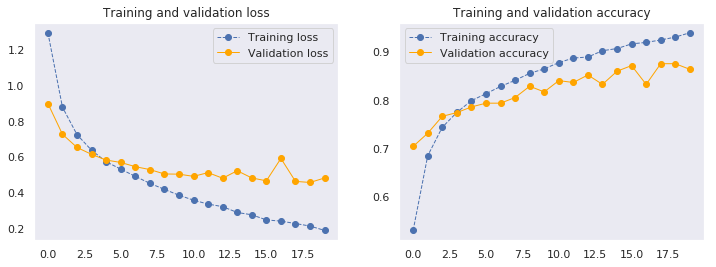

In [23]:
# Launch the graph and train and validate, saving the model.
sess = tf.Session()

# Initialize variables.
sess.run(tf.global_variables_initializer())

print('Training.....')

# Start-time used for printing time-usage below.
start_time = time.time()
best_val_loss = float("inf")

# Write summary in tensorboard format
TB_DIR = 'tmp/tensorboard/TF_CNN'
if not os.path.isdir(TB_DIR):
    os.makedirs(TB_DIR)
writer = tf.summary.FileWriter(TB_DIR, sess.graph)

tot_loss_list = []
tot_acc_list = []
tot_loss_val_list = []
tot_acc_val_list = []
#  Exectue training and validation in each epoch
for i in range(EPOCHS):
    tot_loss = 0.0
    tot_acc = 0.0
    tot_loss_val = 0.0
    tot_acc_val = 0.0

    # Execute training.
    # Set training data in Numpy array and batch size to Iterator.
    sess.run(train_init_op, feed_dict={X: x_train_tr, y: y_train_tr, 
                                       batch_size_tr: BATCH_SIZE_TR}) 
    # Calculation in every batch.
    for j in range(n_batches_tr):
        _, loss_value, acc, tr_smr_loss, tr_smr_acc = sess.run([train_op, loss, 
                                            accuracy, train_summary_loss, train_summary_acc], 
                                                               feed_dict={is_training: True})
        # Write summay of training loss and accracy to tensorboard.
        writer.add_summary(tr_smr_loss, j+i*n_batches_tr)
        writer.add_summary(tr_smr_acc, j+i*n_batches_tr)

        tot_loss += loss_value
        tot_acc += acc

    # Execute validation.
    # Set validation data in Numpy array and batch size to Iterator.
    sess.run(val_init_op, feed_dict={X: x_train_val, y: y_train_val, 
                                     batch_size_val: BATCH_SIZE_VAL}) 

    for j in range(n_batches_val):
        loss_value, acc, val_smr_loss, val_smr_acc = sess.run([v_loss, 
                                            v_accuracy, val_summary_loss, val_summary_acc],
                                                             feed_dict={is_training: False})
        # Write summay of validation loss and accracy to tensorboard.
        writer.add_summary(val_smr_loss, j+i*n_batches_tr)
        writer.add_summary(val_smr_acc, j+i*n_batches_tr)

        tot_loss_val += loss_value
        tot_acc_val += acc

    print("Iter: {}, Loss: {:.4f}, Acc: {:4f}, Val_Loss: {:.4f}, Val_Acc: {:4f}".format(i, tot_loss/n_batches_tr, tot_acc/n_batches_tr, tot_loss_val/n_batches_val, tot_acc_val/n_batches_val))
    # Save models in each epoch
    saver.save(sess, os.path.join(SAVE_DIR, "model.ckpt"), i)

    tot_loss_list.append(tot_loss/n_batches_tr)
    tot_acc_list.append(tot_acc/n_batches_tr)
    tot_loss_val_list.append(tot_loss_val/n_batches_val)
    tot_acc_val_list.append(tot_acc_val/n_batches_val)

    if early_stopping:    
            if tot_loss_val < best_val_loss:
                best_val_loss = tot_loss_val
                patience = 0
            else:
                patience += 1

            if patience == early_stopping:
                break

# Plot training and validation loss
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(12,4))

axL.plot(range(len(tot_loss_list)), tot_loss_list, linestyle='dashed', linewidth = 1.0, marker='o', label='Training loss')
axL.plot(range(len(tot_loss_val_list)), tot_loss_val_list, color='orange',  linestyle='solid', linewidth = 1.0, marker='o', label='Validation loss')
axL.set_title('Training and validation loss')
axL.legend()
# plt.savefig(save_path_p1)
axR.plot(range(len(tot_acc_list)), tot_acc_list, linestyle='dashed', linewidth = 1.0, marker='o', label='Training accuracy')
axR.plot(range(len(tot_acc_val_list)), tot_acc_val_list, color='orange',  linestyle='solid', linewidth = 1.0, marker='o', label='Validation accuracy')
axR.set_title('Training and validation accuracy')
axR.legend()

PLOT_DIR = 'tmp/figures/TF_CNN'
if not os.path.isdir(PLOT_DIR):
    os.makedirs(PLOT_DIR)
fig.savefig(os.path.join(PLOT_DIR, 'plot_loss_acc.png'), dpi=300)

# Ending time.
end_time = time.time()

# Difference between start and end-times.
time_dif = end_time - start_time

# Print the time-usage.
print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))
writer.close()

### Showing performance with test data

In [24]:
batch_size_ts = tf.placeholder(tf.int64)
with tf.name_scope("inputs") as scope:
    ts_dataset = tf.data.Dataset.from_tensor_slices((X, y)).batch(batch_size_ts).repeat()
    ts_init_op = iterator.make_initializer(ts_dataset)
sess.run(ts_init_op, feed_dict={X: x_test, y: y_test, batch_size_ts: BATCH_SIZE_TS}) 
pred_test = sess.run([v_prediction], feed_dict={is_training: False})[0]
y_test_le = np.argmax(y_test, axis=1)

In [25]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test_le, pred_test)
print(conf_matrix)

# Create a boolean array whether each image is correctly classified.
correct = (y_test_le == pred_test)

# Calculate the number of correctly classified images.
# When summing a boolean array, False means 0 and True means 1.
correct_sum = correct.sum()
acc = float(correct_sum) /len(pred_test)
# Print the accuracy.
msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
print(msg.format(acc, correct_sum, len(pred_test)))

[[129   0   2   1   0   9   6   0   3   0]
 [  0 137   0   0   0   8   0   0   0   5]
 [  2   2 115   2   0   1  26   0   1   1]
 [  9   0   5  73   3   3  18   1  13   0]
 [  0   0   3   8 106   0   3   4   1   0]
 [  3   3   2   1   0  78   8   0   5   0]
 [  2   0   8   0   0   2 111   0   2   0]
 [  0   0   7   3   2   0   4 134   0   0]
 [  7   0   1  14   0   5   4   0  93   1]
 [  1   0   0   0   0   0   0   0   1 148]]
Accuracy on Test-Set: 83.3% (1124 / 1350)
